# Binary Sentiment Classiﬁcation of IMDB Movie Reviews

I would predict the number of positive and negative reviews based on sentiments by using different classification models. 

#### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os

import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


import warnings
warnings.filterwarnings("ignore")


## Data Description
This dataset contains movie reviews along with their associated binary sentiment polarity labels. The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). 

In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels. 

In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets. In the unsupervised set, reviews of any rating are included and there are an even number of reviews > 5 and <= 5.


## Load Data and Encode labels for sentiments
Download the original dataset from http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz, and then import the train and test dataset.

Lets encode labels: each label is an integer value of either -1 or 1, where -1 is a negative review, and 1 is a positive review.

In [2]:
def get_data(train_test, pos_neg):
    files = os.listdir("{}/{}".format(train_test, pos_neg))
    content = []
    for filename in files:
        with open("{}/{}/{}".format(train_test, pos_neg, filename), 'r', encoding = 'UTF-8') as f:
            content.append(f.read())
    content = pd.DataFrame(content, columns =['review'])
    if pos_neg == 'pos':
        content['label'] = 1
    else:
        content['label'] = -1
    return content

train_pos = get_data("train", "pos")
train_neg = get_data("train", "neg")
test_pos = get_data("test", "pos")
test_neg = get_data("test", "neg")

In [3]:
train = pd.concat([train_pos, train_neg])
test = pd.concat([test_pos, test_neg])
input_cols = ['review']
output_cols = ['label']
x_train = train[input_cols]
y_train = train[output_cols]
x_test = test[input_cols]
y_test = test[output_cols]

In [4]:
x_train

,review
0,Bromwell High is a cartoon comedy. It ran at t...
1,Homelessness (or Houselessness as George Carli...
2,Brilliant over-acting by Lesley Ann Warren. Be...
3,This is easily the most underrated film inn th...
4,This is not the typical Mel Brooks film. It wa...
...,...
12495,"Towards the end of the movie, I felt it was to..."
12496,This is the kind of movie that my enemies cont...
12497,I saw 'Descent' last night at the Stockholm Fi...
12498,Some films that you pick up for a pound turn o...


In [5]:
y_train

,label
0,1
1,1
2,1
3,1
4,1
...,...
12495,-1
12496,-1
12497,-1
12498,-1


## Words feature in review
Now use the CountVectorizer provided by the scikit-learn library to vectorize sentences. It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences. This vocabulary can then be used to create a feature vector of the count of the words:

In [6]:
x = pd.concat([x_train,x_test], ignore_index=True)

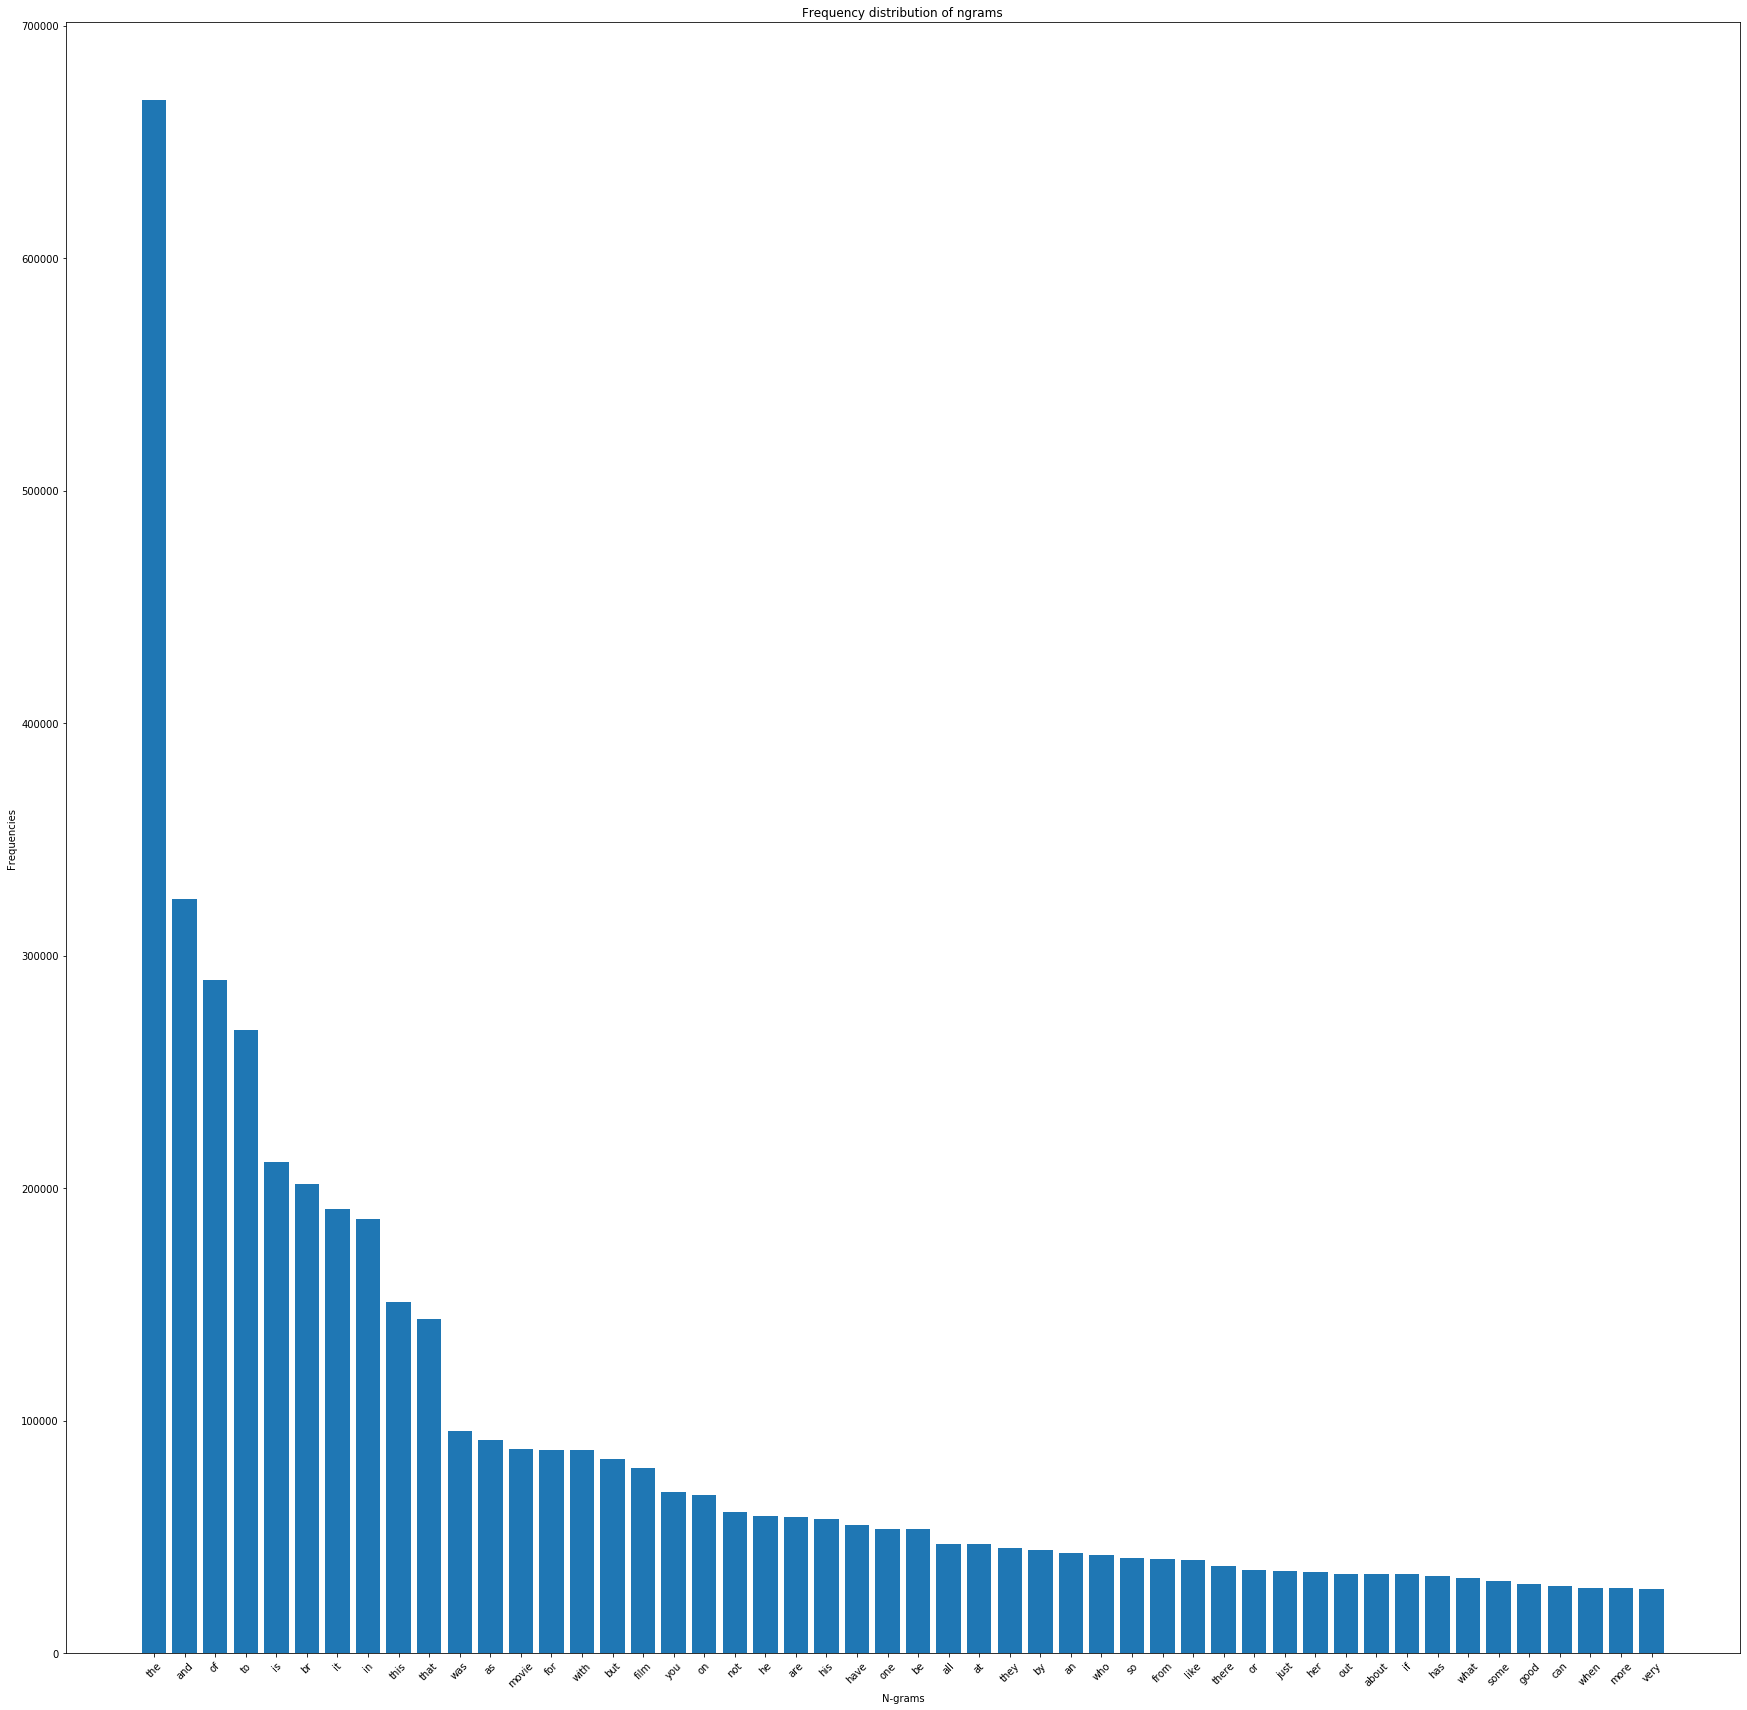

In [7]:
vectorizer = CountVectorizer()
# So, we get such structure:
#        | word1  | word2  |  word3 | word4
# text1  |   1    |    1   |   1    |   0
# text2  |   0    |    1   |   1    |   0
# text3  |   2    |    1   |   0    |   0
# text4  |   0    |    0   |   0    |   1
vect_texts = vectorizer.fit_transform(list(x['review']))
# ['word1', 'word2', 'word3', 'word4']
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

We can see that, the highest frequency words are the stop words. We do not consider them while performing our analysis, as they don't provide insights as to what the sentiment of the document might be or to which class a document might belong.

## Prepare the Data to feed into the model
Use some of the most important steps that are common in natural language processing (NLP) and are used extensively to clean and preprocess text data which can be feed into the models.

### Text normalization
To normalize the text, the necessary steps I should do are the tokenization and remove stopwords. I would mainly use nltk package to carry out.

In [8]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

### Removing html strips and noise text
Unstructured text usually contains a lot of noise. HTML tags are one of these typical noises, and they are not very valuable for understanding and analyzing text.

In [9]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
x_train['review'] = x_train['review'].apply(denoise_text)
x_test['review'] = x_test['review'].apply(denoise_text)

### Removing special characters
Special characters and symbols are usually non-alphanumeric characters, sometimes even numeric characters, which adds extra noise in unstructured text.

In [10]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column
x_train['review'] = x_train['review'].apply(remove_special_characters)
x_test['review'] = x_test['review'].apply(remove_special_characters)

### Text stemming
The reverse process of obtaining the basic form and the root stem from the form of morphological changes is called stem extraction. Stem extraction helps us to standardize the stem, regardless of its deformation. I will use the popular Porter stemmer.

In [11]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on review column
x_train['review'] = x_train['review'].apply(simple_stemmer)
x_test['review'] = x_test['review'].apply(simple_stemmer)

### Text lemmatization
Remove the affix to get the basic form of the word.

In [12]:
# text lemmatization
def simple_lemmatization(text):
    lem = WordNetLemmatizer()
    text= ' '.join([lem.lemmatize(word) for word in text.split()])
    return text

#Apply function on review column
x_train['review'] = x_train['review'].apply(simple_lemmatization)
x_test['review'] = x_test['review'].apply(simple_lemmatization)

### Removing stopwords
Use the standard stop word list in nltk to delete words that have no or little meaning, especially when building meaningful features from text, also known as stop words or stop words.

In [13]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on review column
x_train['review'] = x_train['review'].apply(remove_stopwords)
x_test['review'] = x_test['review'].apply(remove_stopwords)

{'own', 'this', 'off', 'its', 'further', 'his', 'down', 'having', 'i', 'herself', 'your', 'do', 'yourself', 'it', 'under', 'but', 'between', 'not', 'here', 'their', 'where', 'up', 'out', 'during', 'himself', 'the', 'all', 'more', 'only', 'hers', 'over', 'than', 'each', 'ours', 'no', 'don', 'has', 'is', 'a', 't', 'have', 'same', 'them', 'who', 'about', 'some', 'before', 'of', 'with', 'yourselves', 'can', 'we', 'by', 'are', 'ourselves', 'on', 'theirs', 'to', 'nor', 'should', 'any', 'our', 'in', 'too', 'themselves', 'will', 'and', 's', 'such', 'most', 'be', 'if', 'for', 'being', 'she', 'me', 'then', 'am', 'into', 'him', 'once', 'he', 'her', 'how', 'what', 'both', 'because', 'very', 'been', 'doing', 'below', 'other', 'my', 'had', 'until', 'does', 'these', 'so', 'after', 'which', 'now', 'whom', 'from', 'yours', 'they', 'above', 'at', 'against', 'again', 'or', 'few', 'did', 'you', 'as', 'those', 'were', 'while', 'when', 'myself', 'that', 'an', 'itself', 'through', 'was', 'just', 'there', 'wh

In [14]:
x_train

,review
0,bromwel high cartoon comedi ran time program s...
1,homeless houseless georg carlin state ha issu ...
2,brilliant overact lesley ann warren best drama...
3,thi easili underr film inn brook cannon sure f...
4,thi typic mel brook film wa much le slapstick ...
...,...
12495,toward end movi felt wa technic felt like wa c...
12496,thi kind movi enemi content watch time bloodi ...
12497,saw descent last night stockholm film festiv w...
12498,film pick pound turn rather good 23rd centuri ...


### Bags of words model
It is used to convert text documents to numerical vectors or bag of words.

In [15]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train['review'])
#transformed test reviews
cv_test_reviews=cv.transform(x_test['review'])

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (25000, 4139945)
BOW_cv_test: (25000, 4139945)


### Term Frequency-Inverse Document Frequency model (TFIDF)
It is used to convert text documents to matrix of tfidf features.

In [16]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(x_train['review'])
#transformed test reviews
tv_test_reviews=tv.transform(x_test['review'])

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (25000, 4139945)
Tfidf_test: (25000, 4139945)


## Modelling the dataset

### 1. logistic regression model
Build logistic regression model for both bag of words and tfidf features.

#### Training the model

In [17]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

#### Fitting the model

In [18]:
# Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)

# Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


#### Predicting the model

In [19]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[ 1  1  1 ... -1 -1 -1]
[-1 -1 -1 ... -1 -1 -1]


#### Accuracy score

In [20]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(y_test,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.6032
lr_tfidf_score : 0.50164


#### Classification report

In [21]:
#Classification report for bag of words 
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.56      0.94      0.70     12500
    Negative       0.81      0.27      0.41     12500

    accuracy                           0.60     25000
   macro avg       0.69      0.60      0.55     25000
weighted avg       0.69      0.60      0.55     25000

              precision    recall  f1-score   support

    Positive       0.50      1.00      0.67     12500
    Negative       0.96      0.00      0.01     12500

    accuracy                           0.50     25000
   macro avg       0.73      0.50      0.34     25000
weighted avg       0.73      0.50      0.34     25000



#### Confusion matrix

In [22]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(y_test,lr_bow_predict,labels=[1,-1])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(y_test,lr_tfidf_predict,labels=[1,-1])
print(cm_tfidf)

[[ 3380  9120]
 [  800 11700]]
[[   43 12457]
 [    2 12498]]


### 2.  Stochastic gradient descent or Linear support vector machines.
Use stochastic gradient descent or linear support vector machines for bag of words and tfidf features.

#### Traing the model

In [23]:
#training the linear svm
svm=SGDClassifier(loss='hinge',random_state=42)

#### Fitting the model

In [24]:
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,y_train)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,y_train)
print(svm_tfidf)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


#### Predicting the model

In [25]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


#### Accuracy score

In [26]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(y_test,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(y_test,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.61348
svm_tfidf_score : 0.50388


#### Classification report

In [27]:
#Classification report for bag of words 
svm_bow_report=classification_report(y_test,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(y_test,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.82      0.29      0.43     12500
    Negative       0.57      0.94      0.71     12500

    accuracy                           0.61     25000
   macro avg       0.69      0.61      0.57     25000
weighted avg       0.69      0.61      0.57     25000

              precision    recall  f1-score   support

    Positive       1.00      0.01      0.02     12500
    Negative       0.50      1.00      0.67     12500

    accuracy                           0.50     25000
   macro avg       0.75      0.50      0.34     25000
weighted avg       0.75      0.50      0.34     25000



#### Confusion matrix

In [28]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(y_test,svm_bow_predict,labels=[1,-1])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(y_test,svm_tfidf_predict,labels=[1,-1])
print(cm_tfidf)

[[11709   791]
 [ 8872  3628]]
[[12500     0]
 [12403    97]]


### 3. Multinomial Naive Bayes
Build multinomial Naive Bayes for bag of words and tfidf features.

#### Traing the model

In [29]:
#training the model
mnb=MultinomialNB()

#### Fitting the model

In [30]:
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,y_train)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,y_train)
print(mnb_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


#### Predicting the model

In [31]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[ 1  1  1 ... -1 -1  1]
[ 1  1  1 ... -1 -1  1]


#### Accuracy score

In [32]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(y_test,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.68768
mnb_tfidf_score : 0.68768


#### Classification report

In [33]:
#Classification report for bag of words 
mnb_bow_report=classification_report(y_test,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(y_test,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.67      0.73      0.70     12500
    Negative       0.70      0.65      0.67     12500

    accuracy                           0.69     25000
   macro avg       0.69      0.69      0.69     25000
weighted avg       0.69      0.69      0.69     25000

              precision    recall  f1-score   support

    Positive       0.67      0.73      0.70     12500
    Negative       0.70      0.65      0.67     12500

    accuracy                           0.69     25000
   macro avg       0.69      0.69      0.69     25000
weighted avg       0.69      0.69      0.69     25000



#### Confusion matrix

In [34]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(y_test,mnb_bow_predict,labels=[1,-1])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(y_test,mnb_tfidf_predict,labels=[1,-1])
print(cm_tfidf)

[[8103 4397]
 [3411 9089]]
[[8103 4397]
 [3411 9089]]


## Conclusion

We can observed that both multinomial naive bayes model and logistic regression performing the most well compared to linear support vector machines. The best accuracy score I obtained from these three models is about 70%.

Still we can improve the accuracy of the models by preprocessing data and by using lexicon models like Textblob.